In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Flatten, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *

In [2]:
nlp = spacy.load('en_core_web_lg')

df = pd.read_csv('TrainingDS.csv')
df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
df.head()

,ID,Text,Class
0,1,Trump supporters needed to say the 4 Democrats...,0
1,2,Send them back!!Why the hell are they even her...,1
2,3,Yeah...Im wondering if send them back works fo...,1
3,4,I know you realize you cant pretend that you d...,1
4,5,"Donny, you owe all people an apology for appla...",0


In [3]:
df = pd.read_csv('TrainingDS.csv')
prep_train = PrepareText(df, spell_correct=True, remove_punct=False, get_lemma=True)
prep_train.prepare()
prep_train.save_file('prep_train.csv')
df = prep_train.df

df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
prep_test = PrepareText(df_test, spell_correct=True, remove_punct=False, get_lemma=True)
prep_test.prepare()
prep_test.save_file('prep_test.csv')
df_test = prep_test.df
df.head()

preparing
TO_LOWER
REMOVE_EMOJI
REMOVE_EMOTICONS
CHAT_WORDS_CONVERSION
SPELL_CORRECT
ADD_SPACE
REMOVE_STOPWORDS
REMOVE_URL
GET_LEMMA
preparing
TO_LOWER
REMOVE_EMOJI
REMOVE_EMOTICONS
CHAT_WORDS_CONVERSION
SPELL_CORRECT
ADD_SPACE
REMOVE_STOPWORDS
REMOVE_URL
GET_LEMMA


,ID,Text,Class
0,1,trump supporter need 4 democrats socialist squ...,0
1,2,send back!!why hell -PRON- be sick hearing ifw...,1
2,3,yeah ... -PRON- be wonder send work wife camp ...,1
3,4,know realize can not pretend do not know obama...,1
4,5,donny owe people apology applaud horrible chan...,0


In [4]:
X_train, y_train = df['Text'], df['Class']

In [5]:
maxlen = 50
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [6]:
tokenizer.fit_on_texts(X_train)

In [7]:
sequences = tokenizer.texts_to_sequences(X_train)

In [8]:
index = 0
print(X_train[index])
print(sequences[index])

trump supporter need 4 democrats socialist squad racist trump america supporters america freedom speech trump hyper rally socialist democratic squad rally rally say send migrant socialist democratic
[3, 30, 42, 116, 76, 209, 106, 7, 3, 74, 1930, 74, 530, 225, 3, 1931, 10, 209, 290, 106, 10, 10, 9, 1, 756, 209, 290]


In [9]:
X_train = pad_sequences(sequences, maxlen=maxlen)

In [10]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    3,   30,   42,  116,   76,  209,  106,    7,    3,   74,
        1930,   74,  530,  225,    3, 1931,   10,  209,  290,  106,   10,
          10,    9,    1,  756,  209,  290],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,   57, 1252,  182,    4,    6,  463,  757, 1932,
         150,   17,  150,  210,  363,   61,  150,  151, 1933,  196,  409,
        1934,   20,    3,  117,   44, 1935]])

In [11]:
model = Sequential()
model.add(Embedding(num_words, 200, input_length=maxlen))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(optimizer='nadam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [13]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [14]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

Epoch 1/5
38/38 [==============================] - 19s 403ms/step - loss: 0.6679 - accuracy: 0.6267 - auc: 0.5553 - val_loss: 0.6236 - val_accuracy: 0.6367 - val_auc: 0.7770

Epoch 00001: val_accuracy improved from -inf to 0.63667, saving model to best_model.h5
Epoch 2/5
38/38 [==============================] - 15s 386ms/step - loss: 0.4610 - accuracy: 0.7958 - auc: 0.8570 - val_loss: 0.5037 - val_accuracy: 0.7633 - val_auc: 0.8340

Epoch 00002: val_accuracy improved from 0.63667 to 0.76333, saving model to best_model.h5
Epoch 3/5
38/38 [==============================] - 15s 392ms/step - loss: 0.2391 - accuracy: 0.9150 - auc: 0.9626 - val_loss: 0.5346 - val_accuracy: 0.7300 - val_auc: 0.8281

Epoch 00003: val_accuracy did not improve from 0.76333
Epoch 4/5
38/38 [==============================] - 15s 387ms/step - loss: 0.1374 - accuracy: 0.9583 - auc: 0.9883 - val_loss: 0.6818 - val_accuracy: 0.7367 - val_auc: 0.8253

Epoch 00004: val_accuracy did not improve from 0.76333
Epoch 5/5
38/

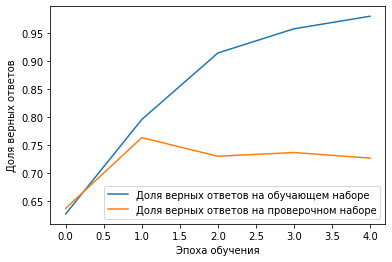

In [15]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [16]:
test_sequences = tokenizer.texts_to_sequences(df_test['Text'])

In [17]:
X_test = pad_sequences(test_sequences, maxlen=maxlen)
y_test = df_test['Class']

In [18]:
model.load_weights(model_save_path)
test_predict = model.predict(X_test)
test_predict = np.where(test_predict >= 0.5,1,0)

In [19]:
df_test['Class'] = test_predict
df_test.head()

,ID,Text,Class
0,1,ye bhi illegal immigrant lag rah hai arc regis...,1
1,2,yeah ask skirt today say ass like do not time ...,1
2,3,need clean selective hearing cobwebs ear tell ...,0
3,4,easy complain criticize offer solution close b...,1
4,5,guess send - -PRON- - back policy friend hit l...,0


In [20]:
df_test.drop('Text', axis=1).to_csv('test_lstm.csv', index=False, sep=',')

Kaggle ~0.767